In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)

2.0.0


In [2]:
def batch_norm(is_training,X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 判断是当前模式是训练模式还是预测模式
    if not is_training:
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / np.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(axis=0)
            var = ((X - mean) ** 2).mean(axis=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。这里我们需要保持
            # X的形状以便后面可以做广播运算
            mean = X.mean(axis=(0, 2, 3), keepdims=True)
            var = ((X - mean) ** 2).mean(axis=(0, 2, 3), keepdims=True)
        # 训练模式下用当前的均值和方差做标准化
        X_hat = (X - mean) / np.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 拉伸和偏移
    return Y, moving_mean, moving_var


#### 接下来，我们自定义一个BatchNorm层。它保存参与求梯度和迭代的拉伸参数gamma和偏移参数beta，同时也维护移动平均得到的均值和方差，以便能够在模型预测时被使用。BatchNorm实例所需指定的num_features参数对于全连接层来说应为输出个数，对于卷积层来说则为输出通道数。该实例所需指定的num_dims参数对于全连接层和卷积层来说分别为2和4。

In [3]:
class BatchNormalization(tf.keras.layers.Layer):
    def __init__(self, decay=0.9, epsilon=1e-5, **kwargs):
        self.decay = decay
        self.epsilon = epsilon
        super(BatchNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma',
                                     shape=[input_shape[-1], ],
                                     initializer=tf.initializers.ones,
                                     trainable=True)
        self.beta = self.add_weight(name='beta',
                                    shape=[input_shape[-1], ],
                                    initializer=tf.initializers.zeros,
                                    trainable=True)
        self.moving_mean = self.add_weight(name='moving_mean',
                                           shape=[input_shape[-1], ],
                                           initializer=tf.initializers.zeros,
                                           trainable=False)
        self.moving_variance = self.add_weight(name='moving_variance',
                                               shape=[input_shape[-1], ],
                                               initializer=tf.initializers.ones,
                                               trainable=False)
        super(BatchNormalization, self).build(input_shape)

    def assign_moving_average(self, variable, value):
        """
        variable = variable * decay + value * (1 - decay)
        """
        delta = variable * self.decay + value * (1 - self.decay)
        return variable.assign(delta)

    @tf.function
    def call(self, inputs, training):
        if training:
            batch_mean, batch_variance = tf.nn.moments(inputs, list(range(len(inputs.shape) - 1)))
            mean_update = self.assign_moving_average(self.moving_mean, batch_mean)
            variance_update = self.assign_moving_average(self.moving_variance, batch_variance)
            self.add_update(mean_update)
            self.add_update(variance_update)
            mean, variance = batch_mean, batch_variance
        else:
            mean, variance = self.moving_mean, self.moving_variance
        output = tf.nn.batch_normalization(inputs,
                                           mean=mean,
                                           variance=variance,
                                           offset=self.beta,
                                           scale=self.gamma,
                                           variance_epsilon=self.epsilon)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape


In [4]:
# 使用批量归一化层的LeNet
net = tf.keras.models.Sequential(
    [tf.keras.layers.Conv2D(filters=6,kernel_size=5),
    BatchNormalization(),
    tf.keras.layers.Activation('sigmoid'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=16,kernel_size=5),
    BatchNormalization(),
    tf.keras.layers.Activation('sigmoid'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120),
    BatchNormalization(),
    tf.keras.layers.Activation('sigmoid'),
    tf.keras.layers.Dense(84),
    BatchNormalization(),
    tf.keras.layers.Activation('sigmoid'),
    tf.keras.layers.Dense(10,activation='sigmoid')]
)


#### 简洁实现
与我们刚刚自己定义的BatchNorm类相比，keras中layers模块定义的BatchNorm类使用起来更加简单。它不需要指定自己定义的BatchNorm类中所需的num_features和num_dims参数值。在keras中，这些参数值都将通过延后初始化而自动获取。下面我们用keras实现使用批量归一化的LeNet。

In [5]:
net = tf.keras.models.Sequential()
net.add(tf.keras.layers.Conv2D(filters=6,kernel_size=5))
net.add(tf.keras.layers.BatchNormalization())
net.add(tf.keras.layers.Activation('sigmoid'))
net.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
net.add(tf.keras.layers.Conv2D(filters=16,kernel_size=5))
net.add(tf.keras.layers.BatchNormalization())
net.add(tf.keras.layers.Activation('sigmoid'))
net.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
net.add(tf.keras.layers.Flatten())
net.add(tf.keras.layers.Dense(120))
net.add(tf.keras.layers.BatchNormalization())
net.add(tf.keras.layers.Activation('sigmoid'))
net.add(tf.keras.layers.Dense(84))
net.add(tf.keras.layers.BatchNormalization())
net.add(tf.keras.layers.Activation('sigmoid'))
net.add(tf.keras.layers.Dense(10,activation='sigmoid'))

In [6]:
# 获取数据
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 数据预处理
def data_scale(x, y):
    x = tf.cast(x, tf.float32)
    x = x / 255.0
    x = tf.reshape(x, (x.shape[0], x.shape[1], 1))
    x = tf.image.resize_with_pad(image=x, target_height=224,target_width=224)
    
    return x, y
# 由于笔记本训练太慢了，使用1000条数据，跑一下先,算力够的可以直接使用全部数据更加明显
train_db = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(20).map(data_scale).batch(128)
test_db = tf.data.Dataset.from_tensor_slices((x_test,y_test)).shuffle(20).map(data_scale).batch(128)

In [7]:
# net.save('vgg.h5')
X = tf.random.uniform((1,224,224,1))

for blk in net.layers:
    print('input shape:\t', X.shape)
    X = blk(X)
    print(blk.name, 'output shape:\t', X.shape)

input shape:	 (1, 224, 224, 1)
conv2d_2 output shape:	 (1, 220, 220, 6)
input shape:	 (1, 220, 220, 6)
batch_normalization_4 output shape:	 (1, 220, 220, 6)
input shape:	 (1, 220, 220, 6)
activation_4 output shape:	 (1, 220, 220, 6)
input shape:	 (1, 220, 220, 6)
max_pooling2d_2 output shape:	 (1, 110, 110, 6)
input shape:	 (1, 110, 110, 6)
conv2d_3 output shape:	 (1, 106, 106, 16)
input shape:	 (1, 106, 106, 16)
batch_normalization_5 output shape:	 (1, 106, 106, 16)
input shape:	 (1, 106, 106, 16)
activation_5 output shape:	 (1, 106, 106, 16)
input shape:	 (1, 106, 106, 16)
max_pooling2d_3 output shape:	 (1, 53, 53, 16)
input shape:	 (1, 53, 53, 16)
flatten_1 output shape:	 (1, 44944)
input shape:	 (1, 44944)
dense_3 output shape:	 (1, 120)
input shape:	 (1, 120)
batch_normalization_6 output shape:	 (1, 120)
input shape:	 (1, 120)
activation_6 output shape:	 (1, 120)
input shape:	 (1, 120)
dense_4 output shape:	 (1, 84)
input shape:	 (1, 84)
batch_normalization_7 output shape:	 (1, 84

In [8]:
# 定义优化器和损失函数
optimizer = tf.keras.optimizers.SGD(lr=1e-2)
loss = tf.keras.losses.sparse_categorical_crossentropy
net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

net.fit_generator(train_db, epochs=10, validation_data=test_db)    # 这里就不跑太多轮了，有机器可以自己调参跑个好的结果
net.summary()

Epoch 1/10
469/469 [==============================] - 48s 103ms/step - loss: 1.4301 - accuracy: 0.5889 - val_loss: 1.3972 - val_accuracy: 0.6680
Epoch 2/10
469/469 [==============================] - 47s 100ms/step - loss: 0.8869 - accuracy: 0.8289 - val_loss: 1.0670 - val_accuracy: 0.6894
Epoch 3/10
469/469 [==============================] - 46s 99ms/step - loss: 0.6812 - accuracy: 0.8500 - val_loss: 0.7818 - val_accuracy: 0.7971
Epoch 4/10
469/469 [==============================] - 46s 99ms/step - loss: 0.5703 - accuracy: 0.8653 - val_loss: 0.6242 - val_accuracy: 0.8383
Epoch 5/10
469/469 [==============================] - 46s 99ms/step - loss: 0.4986 - accuracy: 0.8744 - val_loss: 0.5151 - val_accuracy: 0.8652
Epoch 6/10
469/469 [==============================] - 46s 99ms/step - loss: 0.4494 - accuracy: 0.8810 - val_loss: 0.4793 - val_accuracy: 0.8654
Epoch 7/10
469/469 [==============================] - 46s 99ms/step - loss: 0.4116 - accuracy: 0.8884 - val_loss: 0.4567 - val_accurac

conv2d_2 itput shape:	 (1, 224, 224, 1)
conv2d_2 output shape:	 (1, 220, 220, 6)
(220, 220)
(220, 220)
(220, 220)
(220, 220)
batch_normalization_4 itput shape:	 (1, 220, 220, 6)
batch_normalization_4 output shape:	 (1, 220, 220, 6)
(220, 220)
(220, 220)
(220, 220)
(220, 220)
activation_4 itput shape:	 (1, 220, 220, 6)
activation_4 output shape:	 (1, 220, 220, 6)
(220, 220)
(220, 220)
(220, 220)
(220, 220)
max_pooling2d_2 itput shape:	 (1, 220, 220, 6)
max_pooling2d_2 output shape:	 (1, 110, 110, 6)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
conv2d_3 itput shape:	 (1, 110, 110, 6)
conv2d_3 output shape:	 (1, 106, 106, 16)
(106, 106)
(106, 106)
(106, 106)
(106, 106)
batch_normalization_5 itput shape:	 (1, 106, 106, 16)
batch_normalization_5 output shape:	 (1, 106, 106, 16)
(106, 106)
(106, 106)
(106, 106)
(106, 106)
activation_5 itput shape:	 (1, 106, 106, 16)
activation_5 output shape:	 (1, 106, 106, 16)
(106, 106)
(106, 106)
(106, 106)
(106, 106)
max_pooling2d_3 itput shape:	 (1, 106,

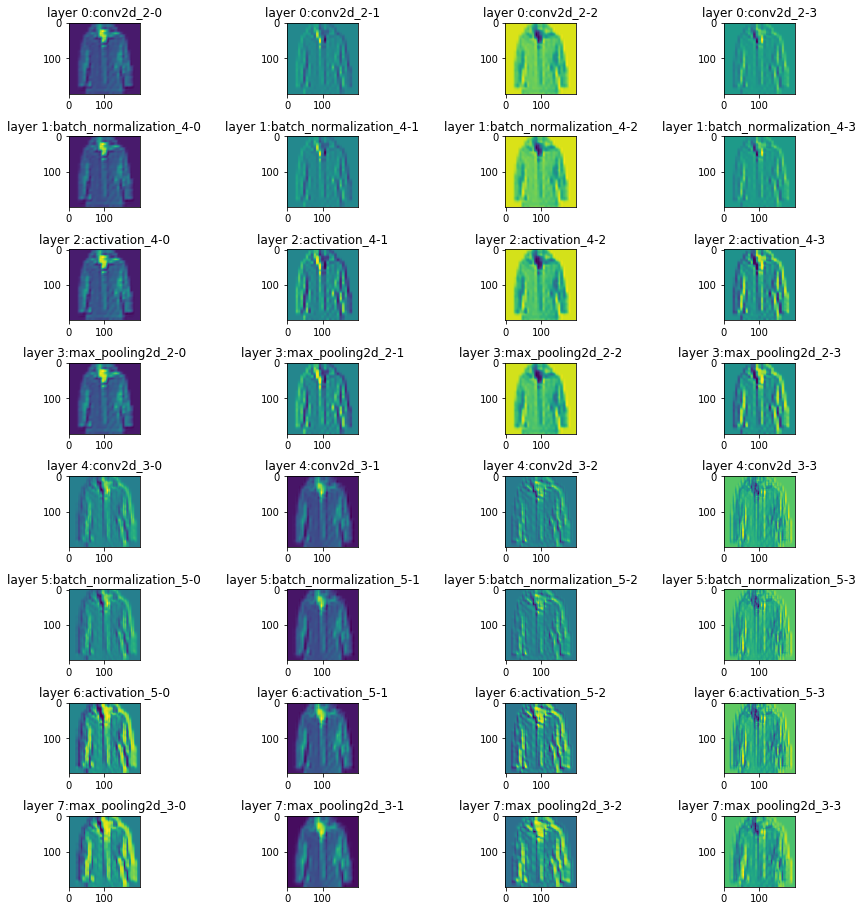

In [10]:
# 展示其中的前八层的特征图
X = next(iter(train_db))[0][0]

def show(X, k,i, name):
    print(X.shape)
    X = tf.expand_dims(X, axis=-1)
    # 将每个图转换为 200 * 200的像素，但这个不是图大小
    X = tf.image.resize(X,  [200,200], method='bilinear')
    X_ = tf.squeeze(X)
    t = plt.subplot(8, 4,  4*k + i + 1)
    t.title.set_text('layer %s:'%k + name + '-' + str(i))
    plt.imshow(X_)


X = tf.expand_dims(X, axis=0)

# 设置图纸大小
plt.figure(figsize=(15, 15))
# 打印前 8 层的部分特征图
for k,blk in enumerate(net.layers[0:8]):
    print(blk.name,'itput shape:\t',X.shape)
#     show(X[0,:,:,0])
    X = blk(X)

    print(blk.name, 'output shape:\t', X.shape)
    # 选择其中的四个通道
    for i in range(4):
        show(X[0,:,:,i], k, i, blk.name)
# 调整子图的间隔
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots,
               # expressed as a fraction of the average axis width
hspace = 0.6   # the amount of height reserved for white space between subplots,
               # expressed as a fraction of the average axis height

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top,
                wspace=wspace, hspace=hspace)


plt.show()

#### 小结
在模型训练时，批量归一化利用小批量上的均值和标准差，不断调整神经网络的中间输出，从而使整个神经网络在各层的中间输出的数值更稳定。
对全连接层和卷积层做批量归一化的方法稍有不同。
批量归一化层和丢弃层一样，在训练模式和预测模式的计算结果是不一样的。
keras提供的BatchNorm类使用起来简单、方便。